In [0]:
! nvidia-smi

Wed May 27 13:27:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.67057 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 286 (delta 57), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (286/286), 12.78 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src
dataset  __init__.py  losses  models  utils


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs       = 96
bs_small = 96
bs_large = 16
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test transform only 'To Tensor' is used.

In [0]:
transform_instance   = dtf.Transforms_custom()
before_norm_list     = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]

transform_mini     = transform_instance.data_transforms(64, 64, before_norm_list)
transform_small    = transform_instance.data_transforms(96, 96, before_norm_list)
transform_orig     = transform_instance.data_transforms(192, 192, before_norm_list)
transform_test     = transform_instance.test_transforms(64,64)

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.

In [0]:
train_ds_b1  = md.Makedata(f1, content_list, t0k,   t80k,  transform_mini)
train_ds_b2  = md.Makedata(f1, content_list, t80k,  t160k, transform_mini)
train_ds_b3  = md.Makedata(f1, content_list, t160k, t220k, transform_mini)
train_ds_b4  = md.Makedata(f1, content_list, t220k, t260k, transform_small)
train_ds_b5  = md.Makedata(f1, content_list, t260k, t280k, transform_orig)
test_ds      = md.Makedata(f1, content_list, t280k, t400k, transform_test)     

In [0]:
train_dl_b1  = DataLoader(train_ds_b1, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b2  = DataLoader(train_ds_b2, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b3  = DataLoader(train_ds_b3, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b4  = DataLoader(train_ds_b4, batch_size = bs_small, shuffle = True, pin_memory = True)
train_dl_b5  = DataLoader(train_ds_b5, batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl      = DataLoader(test_ds,     batch_size = bs,       shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_b1 = next(iter(train_dl_b1))
images_b2 = next(iter(train_dl_b2))
images_b3 = next(iter(train_dl_b3))
images_b4 = next(iter(train_dl_b4))
images_b5 = next(iter(train_dl_b5))
images_ts = next(iter(test_dl))
print('B1:',[(k, v.shape) for k, v in images_b1.items()])
print('B2:',[(k, v.shape) for k, v in images_b2.items()])
print('B3:',[(k, v.shape) for k, v in images_b3.items()])
print('B4:',[(k, v.shape) for k, v in images_b4.items()])
print('B5:',[(k, v.shape) for k, v in images_b5.items()])
print('TS:',[(k, v.shape) for k, v in images_ts.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
TS: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_b5['f1']

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

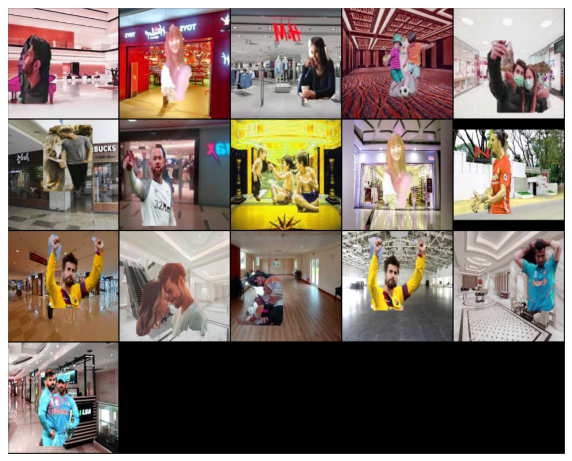

In [0]:
show(imgs, nrow=rows)

### Initializing the model and assigning it to Cuda

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

### Defining Loss Criterion & creating scheduler

In [0]:
#criterion  = nn.BCEWithLogitsLoss()
criterion1  = DiceLoss()
kernel_size = 3
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train.Training_loss()
test_loss_fn  = Test.Testing_loss()

### Reloading model from last saved weights that are present in gdrive

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0527_V14A/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [0]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,11):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs, train_dl_b1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_mask_layers(model)    
  elif epoch < 4:
     batch_size, loader = bs, train_dl_b3
     freezer.freeze_mask_layers(model)  
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_b4
     freezer.freeze_mask_layers(model)  
  elif epoch < 6:
     batch_size, loader  = bs_large, train_dl_b5
     freezer.freeze_mask_layers(model)
  elif epoch < 7:
     batch_size, loader = bs,  train_dl_b1
     freezer.freeze_depth_layers(model)
  elif epoch < 8:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_depth_layers(model) 
  elif epoch < 9:
     batch_size, loader  = bs, train_dl_b3
     freezer.freeze_depth_layers(model)  
  elif epoch < 10:
     batch_size, loader = bs_small, train_dl_b4
     freezer.freeze_depth_layers(model)  
  elif epoch < 11:
     batch_size, loader = bs_large, train_dl_b5
     freezer.freeze_depth_layers(model)      

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs, test_dl
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR1|0|0.040|0.138|0.249|0.253:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/80000 (0%)]	Loss:0.21787 Mask_Loss:0.04008 Dpth_Loss:0.13770 Mask_IOU:0.24916 Dpth_IOU: 0.25275


TR1|0|0.040|0.138|0.249|0.253:   0%|          | 1/834 [00:02<38:45,  2.79s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 1 0


TR1|500|0.039|0.099|0.278|0.641:  60%|██████    | 501/834 [07:26<05:22,  1.03it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 1 500


TR1|832|0.028|0.100|0.217|0.653: 100%|█████████▉| 832/834 [12:13<00:01,  1.18it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.15459 Mask_Loss:0.02753 Dpth_Loss:0.09953 Mask_IOU:0.21679 Dpth_IOU: 0.65332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR1|833|0.029|0.102|0.231|0.659: 100%|██████████| 834/834 [12:15<00:00,  1.13it/s]
TS1|0|0.062|0.100|0.589|0.491:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/120000 (0%)]	Test_Loss: 0.223351 Mask_Loss: 0.06189 Dpth_Loss: 0.09957 Mask_IOU: 0.58857 Dpth_IOU: 0.49054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|1249|0.066|0.099|0.573|0.490: 100%|█████████▉| 1249/1250 [13:56<00:00,  1.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [6245/120000 (100%)]	Test_Loss: 0.230665 Mask_Loss: 0.06578 Dpth_Loss: 0.09910 Mask_IOU: 0.57349 Dpth_IOU: 0.48962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|1249|0.066|0.099|0.573|0.490: 100%|██████████| 1250/1250 [13:57<00:00,  1.49it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR2|0|0.024|0.100|0.195|0.655:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/80000 (0%)]	Loss:0.14721 Mask_Loss:0.02374 Dpth_Loss:0.09973 Mask_IOU:0.19510 Dpth_IOU: 0.65478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|0|0.024|0.100|0.195|0.655:   0%|          | 1/834 [00:02<32:54,  2.37s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 2 0


TR2|500|0.044|0.093|0.331|0.637:  60%|██████    | 501/834 [07:23<05:19,  1.04it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 2 500


TR2|832|0.036|0.099|0.251|0.623: 100%|█████████▉| 832/834 [12:16<00:01,  1.14it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.17061 Mask_Loss:0.03599 Dpth_Loss:0.09863 Mask_IOU:0.25064 Dpth_IOU: 0.62290


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|833|0.019|0.112|0.126|0.640: 100%|██████████| 834/834 [12:18<00:00,  1.13it/s]
TS2|0|0.061|0.092|0.581|0.702:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/120000 (0%)]	Test_Loss: 0.214718 Mask_Loss: 0.06145 Dpth_Loss: 0.09181 Mask_IOU: 0.58060 Dpth_IOU: 0.70216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|1249|0.058|0.091|0.571|0.680: 100%|█████████▉| 1249/1250 [13:19<00:00,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [6245/120000 (100%)]	Test_Loss: 0.207603 Mask_Loss: 0.05845 Dpth_Loss: 0.09071 Mask_IOU: 0.57057 Dpth_IOU: 0.68002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|1249|0.058|0.091|0.571|0.680: 100%|██████████| 1250/1250 [13:21<00:00,  1.56it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Mask Layers


TR3|0|0.037|0.097|0.289|0.665:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/60000 (0%)]	Loss:0.17044 Mask_Loss:0.03651 Dpth_Loss:0.09742 Mask_IOU:0.28870 Dpth_IOU: 0.66484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|0|0.037|0.097|0.289|0.665:   0%|          | 1/625 [00:02<24:55,  2.40s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 3 0


TR3|500|0.035|0.095|0.229|0.633:  80%|████████  | 501/625 [07:10<01:54,  1.09it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 3 500


TR3|624|0.036|0.098|0.261|0.639: 100%|█████████▉| 624/625 [08:59<00:00,  1.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 624 [59904/60000 (100%)]	Loss:0.17078 Mask_Loss:0.03621 Dpth_Loss:0.09836 Mask_IOU:0.26139 Dpth_IOU: 0.63916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|624|0.036|0.098|0.261|0.639: 100%|██████████| 625/625 [09:00<00:00,  1.16it/s]
TS3|0|0.062|0.090|0.588|0.671:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/120000 (0%)]	Test_Loss: 0.214942 Mask_Loss: 0.06236 Dpth_Loss: 0.09022 Mask_IOU: 0.58764 Dpth_IOU: 0.67059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|1249|0.061|0.087|0.571|0.689: 100%|█████████▉| 1249/1250 [12:35<00:00,  1.57it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [6245/120000 (100%)]	Test_Loss: 0.208994 Mask_Loss: 0.06119 Dpth_Loss: 0.08661 Mask_IOU: 0.57114 Dpth_IOU: 0.68880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|1249|0.061|0.087|0.571|0.689: 100%|██████████| 1250/1250 [12:36<00:00,  1.65it/s]
  0%|          | 0/417 [00:00<?, ?it/s]

Freezing Mask Layers


TR4|0|0.042|0.140|0.282|0.442:   0%|          | 0/417 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/40000 (0%)]	Loss:0.22513 Mask_Loss:0.04240 Dpth_Loss:0.14033 Mask_IOU:0.28171 Dpth_IOU: 0.44150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR4|0|0.042|0.140|0.282|0.442:   0%|          | 1/417 [00:03<23:20,  3.37s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 4 0


TR4|415|0.034|0.107|0.250|0.513: 100%|█████████▉| 415/417 [07:47<00:02,  1.12s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 415 [39840/40000 (100%)]	Loss:0.17446 Mask_Loss:0.03395 Dpth_Loss:0.10656 Mask_IOU:0.24990 Dpth_IOU: 0.51274


TR4|416|0.035|0.111|0.205|0.513: 100%|██████████| 417/417 [07:50<00:00,  1.13s/it]
TS4|0|0.066|0.120|0.562|0.488:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/120000 (0%)]	Test_Loss: 0.250987 Mask_Loss: 0.06571 Dpth_Loss: 0.11956 Mask_IOU: 0.56237 Dpth_IOU: 0.48761


TS4|1249|0.056|0.110|0.541|0.530: 100%|█████████▉| 1249/1250 [11:12<00:00,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [6245/120000 (100%)]	Test_Loss: 0.223356 Mask_Loss: 0.05643 Dpth_Loss: 0.11049 Mask_IOU: 0.54123 Dpth_IOU: 0.53044


TS4|1249|0.056|0.110|0.541|0.530: 100%|██████████| 1250/1250 [11:13<00:00,  1.86it/s]
  0%|          | 0/1250 [00:00<?, ?it/s]

Freezing Mask Layers


TR5|0|0.052|0.128|0.231|0.344:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 0 [0/20000 (0%)]	Loss:0.23255 Mask_Loss:0.05243 Dpth_Loss:0.12769 Mask_IOU:0.23067 Dpth_IOU: 0.34439


TR5|0|0.052|0.128|0.231|0.344:   0%|          | 1/1250 [00:01<38:01,  1.83s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 5 0


TR5|500|0.028|0.111|0.174|0.260:  40%|████      | 501/1250 [03:24<05:58,  2.09it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 5 500


TR5|1000|0.041|0.110|0.217|0.323:  80%|████████  | 1001/1250 [06:46<01:59,  2.08it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 5 1000


TR5|1249|0.040|0.098|0.223|0.276: 100%|█████████▉| 1249/1250 [08:27<00:00,  2.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.17755 Mask_Loss:0.03982 Dpth_Loss:0.09790 Mask_IOU:0.22261 Dpth_IOU: 0.27611


TR5|1249|0.040|0.098|0.223|0.276: 100%|██████████| 1250/1250 [08:28<00:00,  2.46it/s]
TS5|0|0.059|0.169|0.543|0.014:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [0/120000 (0%)]	Test_Loss: 0.288026 Mask_Loss: 0.05931 Dpth_Loss: 0.16941 Mask_IOU: 0.54325 Dpth_IOU: 0.01370


TS5|1249|0.059|0.169|0.554|0.013: 100%|█████████▉| 1249/1250 [09:15<00:00,  2.28it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [6245/120000 (100%)]	Test_Loss: 0.287036 Mask_Loss: 0.05894 Dpth_Loss: 0.16915 Mask_IOU: 0.55438 Dpth_IOU: 0.01283


TS5|1249|0.059|0.169|0.554|0.013: 100%|██████████| 1250/1250 [09:16<00:00,  2.25it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR6|0|0.035|0.140|0.252|0.344:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 0 [0/80000 (0%)]	Loss:0.20944 Mask_Loss:0.03471 Dpth_Loss:0.14002 Mask_IOU:0.25213 Dpth_IOU: 0.34382


TR6|0|0.035|0.140|0.252|0.344:   0%|          | 1/834 [00:02<34:42,  2.50s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 6 0


TR6|500|0.036|0.138|0.253|0.345:  60%|██████    | 501/834 [07:38<05:30,  1.01it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 6 500


TR6|832|0.031|0.126|0.252|0.382: 100%|█████████▉| 832/834 [12:43<00:01,  1.07it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.18738 Mask_Loss:0.03091 Dpth_Loss:0.12556 Mask_IOU:0.25237 Dpth_IOU: 0.38182


TR6|833|0.040|0.123|0.282|0.371: 100%|██████████| 834/834 [12:45<00:00,  1.09it/s]
TS6|0|0.064|0.120|0.576|0.409:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [0/120000 (0%)]	Test_Loss: 0.249107 Mask_Loss: 0.06436 Dpth_Loss: 0.12039 Mask_IOU: 0.57569 Dpth_IOU: 0.40921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS6|1249|0.065|0.122|0.578|0.379: 100%|█████████▉| 1249/1250 [10:59<00:00,  1.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [6245/120000 (100%)]	Test_Loss: 0.251796 Mask_Loss: 0.06500 Dpth_Loss: 0.12180 Mask_IOU: 0.57773 Dpth_IOU: 0.37911


TS6|1249|0.065|0.122|0.578|0.379: 100%|██████████| 1250/1250 [11:01<00:00,  1.89it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR7|0|0.048|0.136|0.323|0.373:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 0 [0/80000 (0%)]	Loss:0.23133 Mask_Loss:0.04753 Dpth_Loss:0.13628 Mask_IOU:0.32279 Dpth_IOU: 0.37328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR7|0|0.048|0.136|0.323|0.373:   0%|          | 1/834 [00:02<34:20,  2.47s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 7 0


TR7|500|0.035|0.133|0.280|0.362:  60%|██████    | 501/834 [07:24<05:22,  1.03it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 7 500


TR7|832|0.044|0.126|0.337|0.334: 100%|█████████▉| 832/834 [12:15<00:01,  1.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.21335 Mask_Loss:0.04378 Dpth_Loss:0.12579 Mask_IOU:0.33724 Dpth_IOU: 0.33440


TR7|833|0.034|0.138|0.230|0.377: 100%|██████████| 834/834 [12:17<00:00,  1.13it/s]
TS7|0|0.054|0.120|0.564|0.396:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [0/120000 (0%)]	Test_Loss: 0.228437 Mask_Loss: 0.05422 Dpth_Loss: 0.12001 Mask_IOU: 0.56388 Dpth_IOU: 0.39628


TS7|1249|0.065|0.124|0.577|0.428: 100%|█████████▉| 1249/1250 [11:57<00:00,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [6245/120000 (100%)]	Test_Loss: 0.254854 Mask_Loss: 0.06542 Dpth_Loss: 0.12401 Mask_IOU: 0.57733 Dpth_IOU: 0.42767


TS7|1249|0.065|0.124|0.577|0.428: 100%|██████████| 1250/1250 [11:58<00:00,  1.74it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Depth Layers


TR8|0|0.039|0.127|0.241|0.400:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 0 [0/60000 (0%)]	Loss:0.20464 Mask_Loss:0.03865 Dpth_Loss:0.12734 Mask_IOU:0.24051 Dpth_IOU: 0.40037


TR8|0|0.039|0.127|0.241|0.400:   0%|          | 1/625 [00:02<26:05,  2.51s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 8 0


TR8|500|0.035|0.134|0.244|0.355:  80%|████████  | 501/625 [07:37<01:58,  1.05it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 8 500


TR8|624|0.034|0.133|0.266|0.366: 100%|█████████▉| 624/625 [09:28<00:00,  1.07it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 624 [59904/60000 (100%)]	Loss:0.20156 Mask_Loss:0.03437 Dpth_Loss:0.13282 Mask_IOU:0.26554 Dpth_IOU: 0.36589


TR8|624|0.034|0.133|0.266|0.366: 100%|██████████| 625/625 [09:29<00:00,  1.10it/s]
TS8|0|0.063|0.121|0.572|0.405:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [0/120000 (0%)]	Test_Loss: 0.246570 Mask_Loss: 0.06278 Dpth_Loss: 0.12100 Mask_IOU: 0.57167 Dpth_IOU: 0.40526


TS8|1249|0.060|0.123|0.571|0.403: 100%|█████████▉| 1249/1250 [12:10<00:00,  1.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [6245/120000 (100%)]	Test_Loss: 0.242857 Mask_Loss: 0.06011 Dpth_Loss: 0.12263 Mask_IOU: 0.57065 Dpth_IOU: 0.40303


TS8|1249|0.060|0.123|0.571|0.403: 100%|██████████| 1250/1250 [12:11<00:00,  1.71it/s]
  0%|          | 0/417 [00:00<?, ?it/s]

Freezing Depth Layers


TR9|0|0.045|0.116|0.300|0.349:   0%|          | 0/417 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 0 [0/40000 (0%)]	Loss:0.20615 Mask_Loss:0.04514 Dpth_Loss:0.11587 Mask_IOU:0.30024 Dpth_IOU: 0.34915


TR9|0|0.045|0.116|0.300|0.349:   0%|          | 1/417 [00:03<23:37,  3.41s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 9 0


TR9|415|0.034|0.122|0.253|0.357: 100%|█████████▉| 415/417 [07:53<00:02,  1.12s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 415 [39840/40000 (100%)]	Loss:0.19033 Mask_Loss:0.03411 Dpth_Loss:0.12210 Mask_IOU:0.25325 Dpth_IOU: 0.35728


TR9|416|0.036|0.117|0.228|0.359: 100%|██████████| 417/417 [07:56<00:00,  1.14s/it]
TS9|0|0.061|0.139|0.544|0.077:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [0/120000 (0%)]	Test_Loss: 0.261180 Mask_Loss: 0.06108 Dpth_Loss: 0.13902 Mask_IOU: 0.54372 Dpth_IOU: 0.07732


TS9|1249|0.061|0.137|0.559|0.131: 100%|█████████▉| 1249/1250 [11:41<00:00,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [6245/120000 (100%)]	Test_Loss: 0.259196 Mask_Loss: 0.06090 Dpth_Loss: 0.13740 Mask_IOU: 0.55908 Dpth_IOU: 0.13149


TS9|1249|0.061|0.137|0.559|0.131: 100%|██████████| 1250/1250 [11:43<00:00,  1.78it/s]
  0%|          | 0/1250 [00:00<?, ?it/s]

Freezing Depth Layers


TR10|0|0.043|0.116|0.175|0.305:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 0 [0/20000 (0%)]	Loss:0.20190 Mask_Loss:0.04295 Dpth_Loss:0.11600 Mask_IOU:0.17488 Dpth_IOU: 0.30540


TR10|0|0.043|0.116|0.175|0.305:   0%|          | 1/1250 [00:01<38:47,  1.86s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 10 0


TR10|500|0.056|0.107|0.341|0.271:  40%|████      | 501/1250 [03:25<06:05,  2.05it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 10 500


TR10|1000|0.036|0.112|0.220|0.262:  80%|████████  | 1001/1250 [06:48<02:01,  2.04it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V14A.pt Epoch & Batch-ID: 10 1000


TR10|1249|0.031|0.116|0.235|0.232: 100%|█████████▉| 1249/1250 [08:29<00:00,  2.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.17765 Mask_Loss:0.03077 Dpth_Loss:0.11612 Mask_IOU:0.23542 Dpth_IOU: 0.23163


TR10|1249|0.031|0.116|0.235|0.232: 100%|██████████| 1250/1250 [08:30<00:00,  2.45it/s]
TS10|0|0.062|0.156|0.530|0.017:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [0/120000 (0%)]	Test_Loss: 0.279411 Mask_Loss: 0.06160 Dpth_Loss: 0.15621 Mask_IOU: 0.52995 Dpth_IOU: 0.01727


TS10|1249|0.058|0.157|0.546|0.029: 100%|█████████▉| 1249/1250 [10:29<00:00,  1.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [6245/120000 (100%)]	Test_Loss: 0.272664 Mask_Loss: 0.05773 Dpth_Loss: 0.15721 Mask_IOU: 0.54620 Dpth_IOU: 0.02940


TS10|1249|0.058|0.157|0.546|0.029: 100%|██████████| 1250/1250 [10:31<00:00,  1.98it/s]


In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.1781304031610489, 0.1757918745279312, 0.17089241743087769, 0.19212470948696136, 0.19922220706939697, 0.21000538766384125, 0.20772631466388702, 0.20729149878025055, 0.19709379971027374, 0.19922633469104767]
train_mask_loss_all: [0.03732958436012268, 0.037659384310245514, 0.037376534193754196, 0.03904442861676216, 0.042299747467041016, 0.03744586184620857, 0.037621039897203445, 0.037447892129421234, 0.038583241403102875, 0.04266411438584328]
train_depth_loss_all: [0.10347115993499756, 0.10047309100627899, 0.09613925963640213, 0.1140359491109848, 0.11462260782718658, 0.13511371612548828, 0.13248443603515625, 0.13239595293998718, 0.11992736160755157, 0.1138979122042656]
train_mask_iou_all: [0.26397015174293215, 0.2641807289555487, 0.26262474743852543, 0.26638179282412905, 0.2531992968441823, 0.2641648756563687, 0.2635522935713325, 0.26400105600000057, 0.2615965554476922, 0.2507182632437915]
train_depth_iou_all: [0.6295549250630956, 0.639674420684455, 0.6556932312875764, 

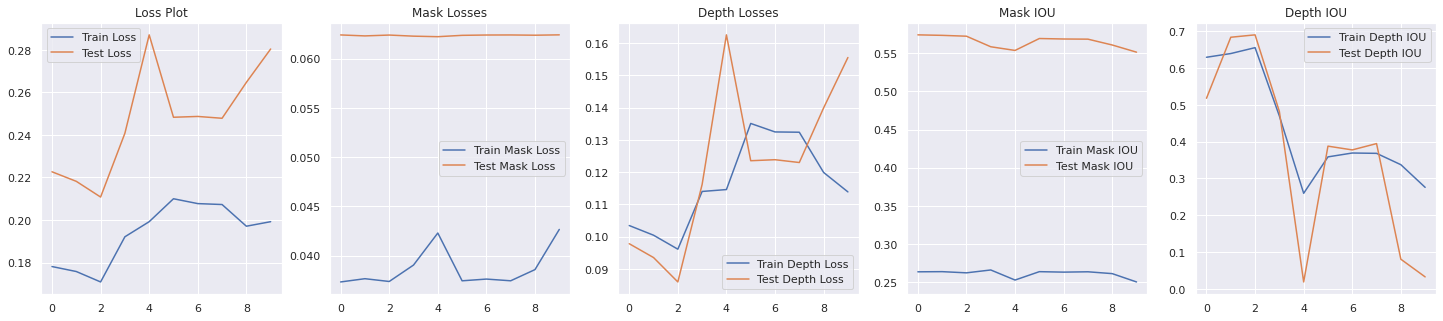

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
transform_test_display   = transform_instance.test_transforms(192,192)
test_ds_display          = md.Makedata(f1, content_list, 395000, 400000, transform_test)
test_dl_display          = DataLoader(test_ds_display,batch_size = 8,shuffle = True, pin_memory = True)

In [0]:
batch_size, loader, epoch = 8, test_dl_display, 11
test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)

TS11|0|0.073|0.147|0.492|0.061:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 11 [0/5000 (0%)]	Test_Loss: 0.293034 Mask_Loss: 0.07281 Dpth_Loss: 0.14741 Mask_IOU: 0.49174 Dpth_IOU: 0.06091


TS11|624|0.051|0.153|0.538|0.059: 100%|█████████▉| 622/625 [00:26<00:00, 22.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 11 [3120/5000 (100%)]	Test_Loss: 0.253849 Mask_Loss: 0.05064 Dpth_Loss: 0.15257 Mask_IOU: 0.53844 Dpth_IOU: 0.05917


TS11|624|0.051|0.153|0.538|0.059: 100%|██████████| 625/625 [00:26<00:00, 23.46it/s]
